In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time

import mne
from mne.preprocessing import ICA, create_eog_epochs
from mne.channels import combine_channels

# Preprocessing

### Load Data

In [25]:
#Read raw data with MNE
raw = mne.io.read_raw_brainvision('../Raw_data/P01.vhdr', preload=False)
raw.pick_types(meg=False, eeg=True, eog=False).load_data()

reject = dict(eeg=180e-6)
raw.drop_channels(['ExG 1','ExG 2', 'A2'])  # ExG Channel 제거

#Get event code from annotations(vmrk)
events, events_id = mne.events_from_annotations(raw, event_id='auto')

raw, events = raw.resample(256, events=events)

events_id

Extracting parameters from ../Raw_data/P01.vhdr...
Setting channel info structure...
Reading 0 ... 5539597  =      0.000 ... 11079.194 secs...
Used Annotations descriptions: ['Stimulus/10', 'Stimulus/100', 'Stimulus/101', 'Stimulus/102', 'Stimulus/103', 'Stimulus/11', 'Stimulus/110', 'Stimulus/111', 'Stimulus/112', 'Stimulus/113', 'Stimulus/20', 'Stimulus/200', 'Stimulus/201', 'Stimulus/202', 'Stimulus/203', 'Stimulus/30', 'Stimulus/40', 'Stimulus/50', 'Stimulus/56', 'Stimulus/57', 'Stimulus/60', 'Stimulus/70', 'Stimulus/80', 'Stimulus/98', 'Stimulus/99']


{'Stimulus/10': 10001,
 'Stimulus/100': 10002,
 'Stimulus/101': 10003,
 'Stimulus/102': 10004,
 'Stimulus/103': 10005,
 'Stimulus/11': 10006,
 'Stimulus/110': 10007,
 'Stimulus/111': 10008,
 'Stimulus/112': 10009,
 'Stimulus/113': 10010,
 'Stimulus/20': 10011,
 'Stimulus/200': 10012,
 'Stimulus/201': 10013,
 'Stimulus/202': 10014,
 'Stimulus/203': 10015,
 'Stimulus/30': 10016,
 'Stimulus/40': 10017,
 'Stimulus/50': 10018,
 'Stimulus/56': 10019,
 'Stimulus/57': 10020,
 'Stimulus/60': 10021,
 'Stimulus/70': 10022,
 'Stimulus/80': 10023,
 'Stimulus/98': 10024,
 'Stimulus/99': 10025}

### Assign Sensor Location

In [26]:
# Sensor Location (Topological)
# https://mne.tools/stable/auto_tutorials/intro/plot_40_sensor_locations.html#sphx-glr-auto-tutorials-intro-plot-40-sensor-locations-py
montage = mne.channels.make_standard_montage(kind='standard_1020')  # 10-20 system montage
raw.set_montage(montage)

<RawBrainVision | P01.eeg, 29 x 2836274 (11079.2 s), ~627.6 MB, data loaded>

### High / Low pass filter & Rereference (average)

In [27]:
#raw.notch_filter(50)
raw.filter(l_freq=0.5,h_freq=None,fir_design='firwin')   #high pass filter with fir filter
raw.filter(l_freq=None,h_freq=40,fir_design='firwin')    #low pass filter  with fir filter

raw.set_eeg_reference(ref_channels='average')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1691 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 85 samples (0.332 sec)



[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    6.6s finished


<RawBrainVision | P01.eeg, 29 x 2836274 (11079.2 s), ~627.6 MB, data loaded>

<ipython-input-28-93dcce355278>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, event_id=events_id, sfreq=256)


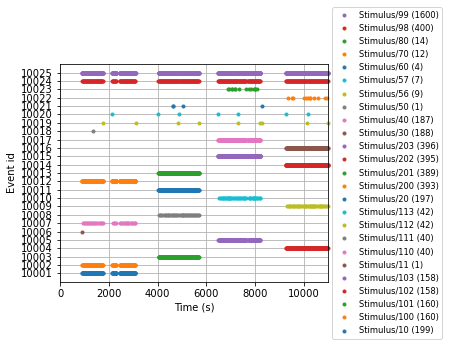

In [28]:
mne.viz.plot_events(events, event_id=events_id, sfreq=256)

events_id={'Normal0':10002,'Normal1':10003,'Normal2':10004,'Normal3':10005,'odd0':10007,'odd1':10008,'odd2':10009,'odd3':10010}  #redifine the events_id
events = mne.pick_events(events, include=[10002, 10003, 10004, 10005,  10007, 10008, 10009, 10010])  #pick events  that we interested

# ICA

Not setting metadata
800 matching events found
Setting baseline interval to [-0.80078125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 800 events and 462 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Fitting ICA to data using 29 channels (please be patient, this may take a while)


<ipython-input-29-5b902af242ed>:6: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica=ICA(n_components=28, method='fastica', random_state=89).fit(epochs_ica, reject=reject)  #define the parameter of ica and fit it to epochs
<ipython-input-29-5b902af242ed>:6: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica=ICA(n_components=28, method='fastica', random_state=89).fit(epochs_ica, reject=reject)  #define the parameter of ica and fit it to epochs


Selecting by number: 28 components
Fitting ICA took 20.7s.


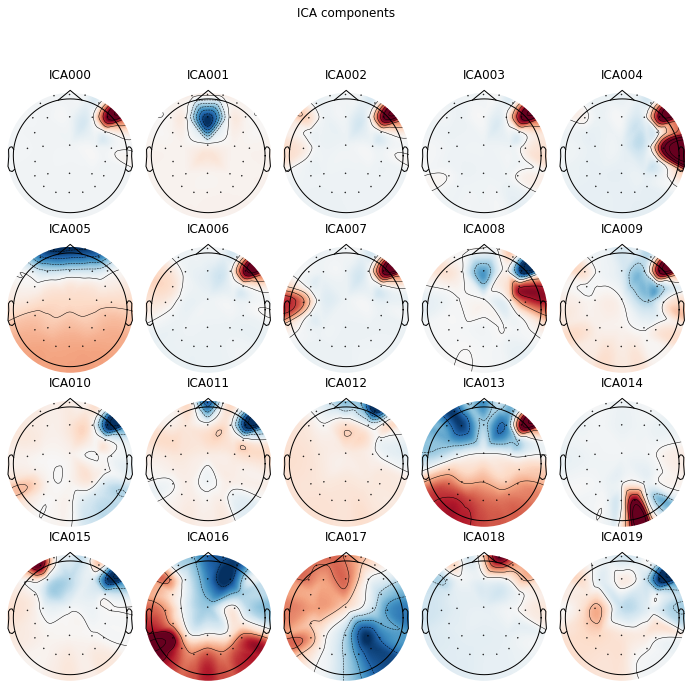

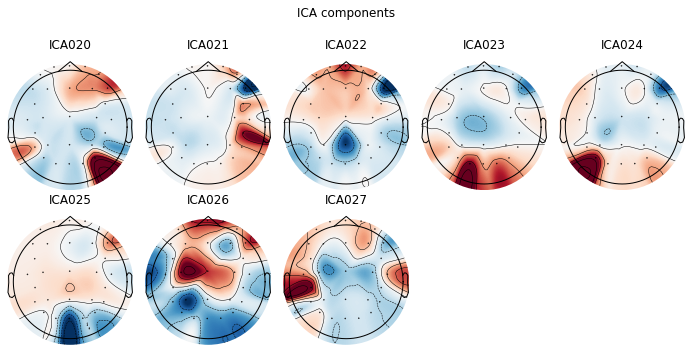

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x357.12 with 8 Axes>]

In [29]:
epochs_ica = mne.Epochs(raw, events=events, event_id=events_id, preload=True, tmin=-0.8, tmax=1.0)

from autoreject import get_rejection_threshold
reject = get_rejection_threshold(epochs_ica)

ica=ICA(n_components=28, method='fastica', random_state=89).fit(epochs_ica, reject=reject)  #define the parameter of ica and fit it to epochs
ica.plot_components()

In [30]:
#ica.exclude = [5]  # details on how we picked these are omitted here
#ica.plot_properties(raw, picks=ica.exclude)
#ica.plot_sources(inst=raw)

orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)  # remove the component that we selected

Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 0 ICA components
    Projecting back using 29 PCA components


<RawBrainVision | P01.eeg, 29 x 2836274 (11079.2 s), ~627.6 MB, data loaded>

### Make Epoch

In [31]:
epochs = mne.Epochs(raw, events=events, event_id=events_id, baseline=(-0.2, 0), preload=True, tmin=-0.2, tmax=0.5, reject=dict(eeg=150e-6))  #epoch and reject those larger than 300 microvolt
#epochs.apply_baseline(baseline=(-0.2, 0))

epochs
#epochs.plot()


Not setting metadata
800 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 800 events and 180 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF7', 'Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp1', 'Fp2']
    Rejecting  epoch based o

Number of events,660
Events,Normal0: 134Normal1: 130Normal2: 125Normal3: 135odd0: 36odd1: 31odd2: 33odd3: 36
Time range,-0.199 – 0.500 sec
Baseline,-0.200 – 0.000 sec


# Plot ERP

### Average

https://neuraldatascience.io/7-eeg/erp_averaging.html

combining channels using "mean"
combining channels using "mean"


<ipython-input-33-2f2fc6a55a0f>:13: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left', ylim=dict(eeg=[-ytick, ytick]), title='ERP (Condition_' + str(i) + ')')


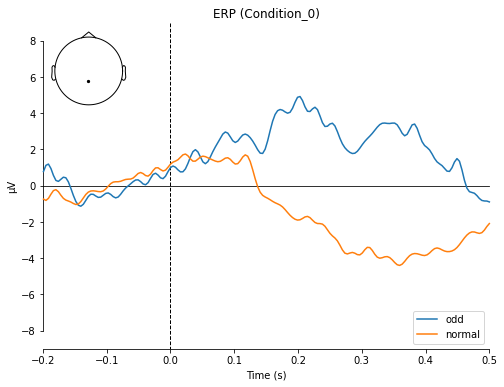

combining channels using "mean"
combining channels using "mean"


<ipython-input-33-2f2fc6a55a0f>:13: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left', ylim=dict(eeg=[-ytick, ytick]), title='ERP (Condition_' + str(i) + ')')


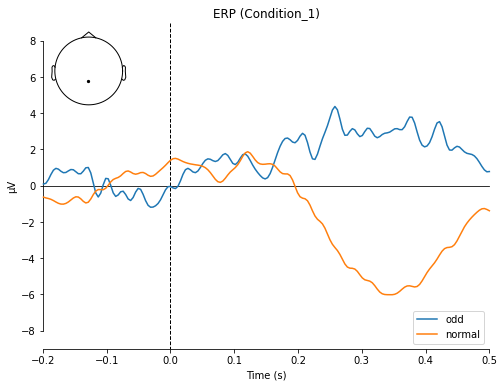

combining channels using "mean"
combining channels using "mean"


<ipython-input-33-2f2fc6a55a0f>:13: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left', ylim=dict(eeg=[-ytick, ytick]), title='ERP (Condition_' + str(i) + ')')


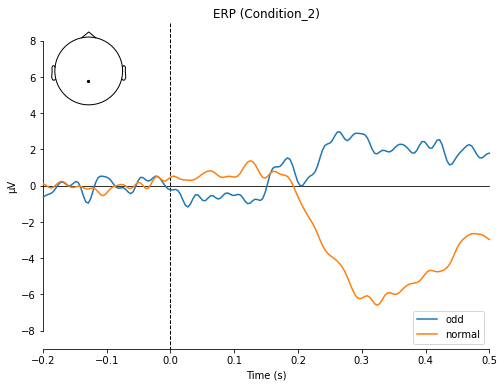

combining channels using "mean"
combining channels using "mean"


<ipython-input-33-2f2fc6a55a0f>:13: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left', ylim=dict(eeg=[-ytick, ytick]), title='ERP (Condition_' + str(i) + ')')


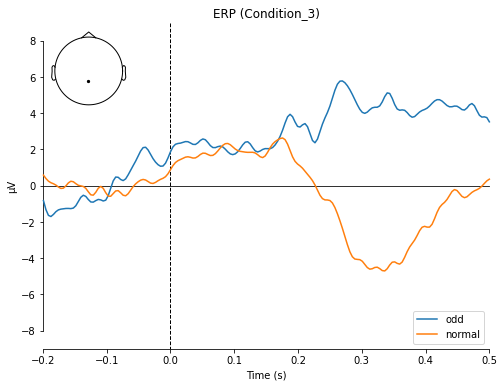

In [33]:
ytick = 9

for i in range(4):
    evoked_normal = epochs['Normal'+str(i)].average()
    evoked_odd = epochs['odd'+str(i)].average()

    #evoked_odd.plot(gfp=True)
    #evoked_normal.plot(gfp=True)

    condition_index={'odd':evoked_odd,'normal':evoked_normal} #set parameter for plot ERP
    roi = ['Oz','P3', 'Pz', 'P4']  # Able to draw multiple channel average (picks=roi)

    mne.viz.plot_compare_evokeds(condition_index, picks=['Pz'], ci=None, combine='mean',legend='lower right',show_sensors='upper left', ylim=dict(eeg=[-ytick, ytick]), title='ERP (Condition_' + str(i) + ')')

### Difference Waveform

combining channels using "mean"


<ipython-input-37-739a9f190bfa>:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, picks=['Pz'], show_sensors='upper right', combine='mean', ylim=dict(eeg=[-ytick, ytick]), title='Difference Wave (Condition_' + str(i) + ')')


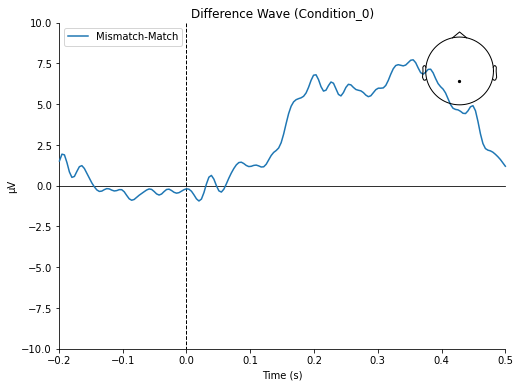

combining channels using "mean"


<ipython-input-37-739a9f190bfa>:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, picks=['Pz'], show_sensors='upper right', combine='mean', ylim=dict(eeg=[-ytick, ytick]), title='Difference Wave (Condition_' + str(i) + ')')


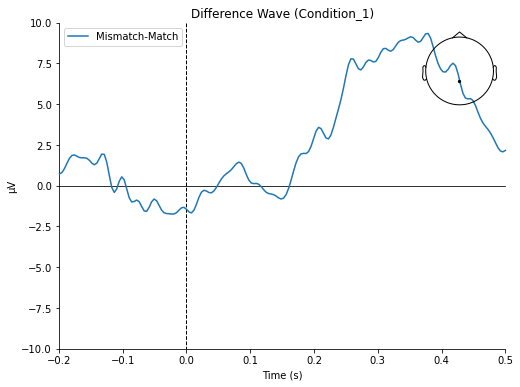

combining channels using "mean"


<ipython-input-37-739a9f190bfa>:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, picks=['Pz'], show_sensors='upper right', combine='mean', ylim=dict(eeg=[-ytick, ytick]), title='Difference Wave (Condition_' + str(i) + ')')


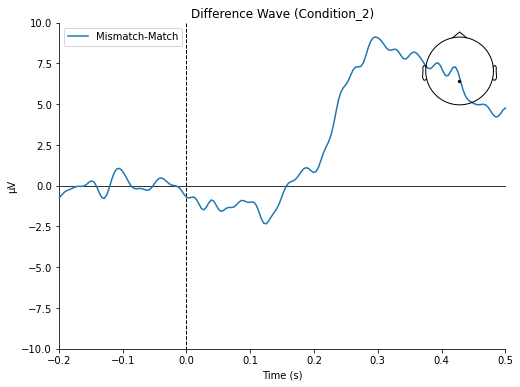

<ipython-input-37-739a9f190bfa>:11: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, picks=['Pz'], show_sensors='upper right', combine='mean', ylim=dict(eeg=[-ytick, ytick]), title='Difference Wave (Condition_' + str(i) + ')')


combining channels using "mean"


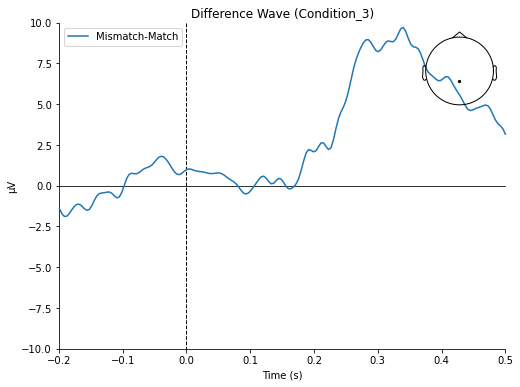

In [37]:
ytick = 10

for i in range(4):
    evoked_normal = epochs['Normal'+str(i)].average()
    evoked_odd = epochs['odd'+str(i)].average()

    evokeds_diff = mne.combine_evoked([evoked_odd, evoked_normal], weights=[1, -1])

    evokeds_diff

    mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, picks=['Pz'], show_sensors='upper right', combine='mean', ylim=dict(eeg=[-ytick, ytick]), title='Difference Wave (Condition_' + str(i) + ')')

### Scalp Distribution of the Difference

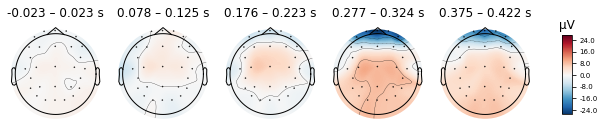

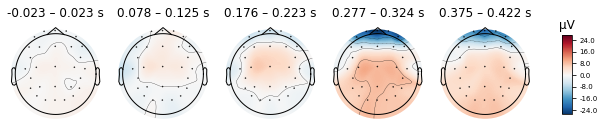

In [39]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, evokeds_diff.tmax, 0.1)

evokeds_diff.plot_topomap(times=times, average=0.050)